In [ ]:
#last edited 5/2/2020, updated for VT presentation 1/14/2021, contains test-retest scores for background, intrinsic, resting state, and concatenated functional connectivities

In [1]:
#quickstart
from pathlib import Path
import pandas as pd
from bids import BIDSLayout
from joblib import Parallel, delayed
import nilearn
import nibabel as nib
import nltools.prefs as prf
from nilearn import datasets, image, plotting, input_data
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, index_img
import numpy as np
import matplotlib.pylab as plt

import rpy2
from rpy2.robjects.packages import importr
from pymer4 import Lmer
psych = importr('psych')


import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

import os
import glob
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from nltools.stats import fdr, one_sample_permutation
from copy import deepcopy
from nltools.utils import get_anatomical
import nltools.plotting as nlplt
from datetime import date
from joblib import Parallel, delayed

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure


import sys
import pandas as pd
import rpy2
from rpy2.robjects.packages import importr
from pymer4 import Lmer
psych = importr('psych')
import numpy as np

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

import os
import glob
import seaborn as sns
from statistics import mean
#dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/dat_paths_11272019.csv') 
#atlas = image.load_img('/data/MBDU/midla/notebooks/campcc/hox_msdl_atlas.nii.gz')
#sub1 = image.load_img('/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmrip

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

In [2]:
dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/merged_paths_for_icc.csv')

In [3]:
cfd_dict = {0:'cc',
           1:'ccm',
           2:'ccmp',
           3:'ccmt',
           4:'ccmpt'}

In [1]:
def load_data(path):
    import pandas as pd
    try:
        dat = pd.read_csv(path, engine='python')
        name_parts = path.as_posix().split("/")[-1].split('_')
        dat['timeseries'] = name_parts[0]
        dat['boot'] = name_parts[3]
        dat['cfd'] = name_parts[-1]
        dat = dat.loc[dat.type == 'ICC2', ['ICC', 'F', 'lower bound', 'upper bound', 'measure', 'timeseries', 'boot', 'cfd']]
        return dat
    except PermissionError:
        os.remove(path)
bs_res_dir = Path('/data/MBDU/midla/notebooks/campcc/mid_v2/test_retest/bootstraps/')
paths = sorted(bs_res_dir.glob('*.csv'))
bs_reses = Parallel(n_jobs=10, verbose=10)(delayed(load_data)(path) for path in paths)
bs_reses = [load_data(path) for path in paths]
bs_res = pd.concat(bs_reses, ignore_index=True)
bs_res.to_csv('/data/MBDU/midla/notebooks/campcc/mid_v2/test_retest/all_bs_results.csv', index=None)

NameError: name 'Path' is not defined

In [19]:
paths = [path for path in paths if 'concat_ifc' in path.as_posix()]

In [22]:
name_parts = paths[0].as_posix().split("/")[-1].split('_')

In [27]:
'_'.join(name_parts[0:2])

'concat_ifc'

In [28]:
def load_data(path):
    import pandas as pd
    dat = pd.read_csv(path, engine='python')
    name_parts = path.as_posix().split("/")[-1].split('_')
    if 'concat_ifc' in path.as_posix():
        dat['timeseries'] = '_'.join(name_parts[0:2])
    else:
        dat['timeseries'] = name_parts[0]
    dat['boot'] = name_parts[3]
    dat['cfd'] = name_parts[-1]
    dat = dat.loc[dat.type == 'ICC2', ['ICC', 'F', 'lower bound', 'upper bound', 'measure', 'timeseries', 'boot', 'cfd']]
    return dat
bs_res_dir = Path('/data/MBDU/midla/notebooks/campcc/test_retest/bootstraps/')
paths = sorted(bs_res_dir.glob('*.csv'))
bs_reses = Parallel(n_jobs=10, verbose=10)(delayed(load_data)(path) for path in paths)
bs_reses = [load_data(path) for path in paths]
bs_res = pd.concat(bs_reses, ignore_index=True)
bs_res.to_csv('/data/MBDU/midla/notebooks/campcc/test_retest/all_bs_results.csv', index=None)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1977s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done  86 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done 116 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done 146 tasks      | elapsed:    8.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done 214 tasks      | elapsed:    9.3s
[Parallel(n_jobs=10)]: Done 252 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done 290 ta

[Parallel(n_jobs=10)]: Done 18116 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 18386 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 18660 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done 18934 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done 19212 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 19490 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 19772 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 20054 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 20340 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 20626 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 20916 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 21206 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 21500 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 21794 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 22092 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 22390 tasks 

In [2]:
bs_res = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/all_bs_results.csv')

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
bs_res.loc[bs_res['timeseries'] == 'concat_ifc'].groupby(['cfd','boot'])[['ICC']].mean().reset_index().groupby(['cfd']).agg(['mean', 'std', 'count'])

ICC          
               mean std count
cfd                          
cc.csv     0.541750 NaN     1
ccm.csv    0.493755 NaN     1
ccmp.csv   0.481508 NaN     1
ccmpt.csv  0.319325 NaN     1
ccmt.csv   0.336277 NaN     1

In [3]:
bs_res.groupby(['timeseries',  'cfd', 'boot',])[['ICC']].mean().reset_index().groupby(['timeseries', 'cfd']).agg(['mean', 'std', 'count'])

ICC                
                          mean       std count
timeseries cfd                                
bgc        cc.csv     0.489260  0.035767  1001
           ccm.csv    0.438481  0.046092  1001
           ccmp.csv   0.426597  0.044596  1001
           ccmpt.csv  0.274317  0.019617   995
           ccmt.csv   0.290784  0.020179  1001
concat     cc.csv     0.539915  0.037447  1000
           ccm.csv    0.481706  0.045003  1001
           ccmp.csv   0.470295  0.045989   996
           ccmpt.csv  0.312091  0.022527  1001
           ccmt.csv   0.332508  0.021320  1001
concat_ifc cc.csv     0.541750       NaN     1
           ccm.csv    0.493755       NaN     1
           ccmp.csv   0.481508       NaN     1
           ccmpt.csv  0.319325       NaN     1
           ccmt.csv   0.336277       NaN     1
ifc        cc.csv     0.492465  0.037154  1001
           ccm.csv    0.454499  0.046310  1002
           ccmp.csv   0.442025  0.044765  1001
           ccmpt.csv  0.283617  0.020730  1001
           ccmt.csv   0.296225  0.021119  1001
rs         cc.csv     0.408260  0.050028  1001
           ccm.csv    0.323165  0.047120  1001
           ccmp.csv   0.322489  0.046461   996
           ccmpt.csv  0.181352  0.014420  1001
           ccmt.csv   0.207449  0.014815  1001

In [4]:
bs_res.groupby(['timeseries',  'cfd', 'boot',])[['ICC']].std().reset_index().groupby(['timeseries', 'cfd']).agg(['mean', 'std', 'count'])

ICC                
                          mean       std count
timeseries cfd                                
bgc        cc.csv     0.126846  0.011337  1001
           ccm.csv    0.124515  0.010227  1001
           ccmp.csv   0.127851  0.009617  1001
           ccmpt.csv  0.160449  0.006106   995
           ccmt.csv   0.162477  0.006420  1001
concat     cc.csv     0.129635  0.014102  1000
           ccm.csv    0.124399  0.010982  1001
           ccmp.csv   0.126367  0.010934   996
           ccmpt.csv  0.166774  0.006397  1001
           ccmt.csv   0.166941  0.006591  1001
concat_ifc cc.csv     0.135923       NaN     1
           ccm.csv    0.132949       NaN     1
           ccmp.csv   0.135360       NaN     1
           ccmpt.csv  0.168004       NaN     1
           ccmt.csv   0.167185       NaN     1
ifc        cc.csv     0.126615  0.011470  1001
           ccm.csv    0.125688  0.010398  1002
           ccmp.csv   0.128285  0.010052  1001
           ccmpt.csv  0.159969  0.006246  1001
           ccmt.csv   0.160746  0.006390  1001
rs         cc.csv     0.134885  0.013372  1001
           ccm.csv    0.138307  0.010682  1001
           ccmp.csv   0.140054  0.010013   996
           ccmpt.csv  0.140283  0.005824  1001
           ccmt.csv   0.147537  0.006293  1001

In [57]:
stds = bs_res.groupby(['timeseries',  'cfd', 'boot',])[['ICC']].std().reset_index().groupby(['timeseries', 'cfd']).agg(['mean', 'std', 'count'])
means = bs_res.groupby(['timeseries',  'cfd', 'boot',])[['ICC']].mean().reset_index().groupby(['timeseries', 'cfd']).agg(['mean', 'std', 'count'])

In [813]:
means_boot1 = bs_res.loc[bs_res['boot'] == '00000'].groupby(['timeseries',  'cfd'])[['ICC']].mean().reset_index().groupby(['timeseries', 'cfd']).agg(['mean', 'std', 'count'])

In [60]:
m_bgc_cc = means.loc[('bgc', 'cc.csv'), ('ICC','mean')]
m_bgc_ccm = means.loc[('bgc', 'ccm.csv'), ('ICC','mean')]
m_bgc_ccmp = means.loc[('bgc', 'ccmp.csv'), ('ICC','mean')]
m_bgc_ccmt = means.loc[('bgc', 'ccmt.csv'), ('ICC','mean')]
m_bgc_ccmpt = means.loc[('bgc', 'ccmpt.csv'), ('ICC','mean')]

In [61]:
s_bgc_cc = stds.loc[('bgc', 'cc.csv'), ('ICC','mean')]
s_bgc_ccm = stds.loc[('bgc', 'ccm.csv'), ('ICC','mean')]
s_bgc_ccmp = stds.loc[('bgc', 'ccmp.csv'), ('ICC','mean')]
s_bgc_ccmt = stds.loc[('bgc', 'ccmt.csv'), ('ICC','mean')]
s_bgc_ccmpt = stds.loc[('bgc', 'ccmpt.csv'), ('ICC','mean')]

In [62]:
m_ifc_cc = means.loc[('ifc', 'cc.csv'), ('ICC','mean')]
m_ifc_ccm = means.loc[('ifc', 'ccm.csv'), ('ICC','mean')]
m_ifc_ccmp = means.loc[('ifc', 'ccmp.csv'), ('ICC','mean')]
m_ifc_ccmt = means.loc[('ifc', 'ccmt.csv'), ('ICC','mean')]
m_ifc_ccmpt = means.loc[('ifc', 'ccmpt.csv'), ('ICC','mean')]

In [63]:
s_ifc_cc = stds.loc[('ifc', 'cc.csv'), ('ICC','mean')]
s_ifc_ccm = stds.loc[('ifc', 'ccm.csv'), ('ICC','mean')]
s_ifc_ccmp = stds.loc[('ifc', 'ccmp.csv'), ('ICC','mean')]
s_ifc_ccmt = stds.loc[('ifc', 'ccmt.csv'), ('ICC','mean')]
s_ifc_ccmpt = stds.loc[('ifc', 'ccmpt.csv'), ('ICC','mean')]

In [64]:
m_concat_cc = means.loc[('concat', 'cc.csv'), ('ICC','mean')]
m_concat_ccm = means.loc[('concat', 'ccm.csv'), ('ICC','mean')]
m_concat_ccmp = means.loc[('concat', 'ccmp.csv'), ('ICC','mean')]
m_concat_ccmt = means.loc[('concat', 'ccmt.csv'), ('ICC','mean')]
m_concat_ccmpt = means.loc[('concat', 'ccmpt.csv'), ('ICC','mean')]
s_concat_cc = stds.loc[('concat', 'cc.csv'), ('ICC','mean')]
s_concat_ccm = stds.loc[('concat', 'ccm.csv'), ('ICC','mean')]
s_concat_ccmp = stds.loc[('concat', 'ccmp.csv'), ('ICC','mean')]
s_concat_ccmt = stds.loc[('concat', 'ccmt.csv'), ('ICC','mean')]
s_concat_ccmpt = stds.loc[('concat', 'ccmpt.csv'), ('ICC','mean')]

In [65]:
m_rs_cc = means.loc[('rs', 'cc.csv'), ('ICC','mean')]
m_rs_ccm = means.loc[('rs', 'ccm.csv'), ('ICC','mean')]
m_rs_ccmp = means.loc[('rs', 'ccmp.csv'), ('ICC','mean')]
m_rs_ccmt = means.loc[('rs', 'ccmt.csv'), ('ICC','mean')]
m_rs_ccmpt = means.loc[('rs', 'ccmpt.csv'), ('ICC','mean')]
s_rs_cc = stds.loc[('rs', 'cc.csv'), ('ICC','mean')]
s_rs_ccm = stds.loc[('rs', 'ccm.csv'), ('ICC','mean')]
s_rs_ccmp = stds.loc[('rs', 'ccmp.csv'), ('ICC','mean')]
s_rs_ccmt = stds.loc[('rs', 'ccmt.csv'), ('ICC','mean')]
s_rs_ccmpt = stds.loc[('rs', 'ccmpt.csv'), ('ICC','mean')]

In [66]:
m_concat_ifc_cc = means.loc[('concat_ifc', 'cc.csv'), ('ICC','mean')]
m_concat_ifc_ccm = means.loc[('concat_ifc', 'ccm.csv'), ('ICC','mean')]
m_concat_ifc_ccmp = means.loc[('concat_ifc', 'ccmp.csv'), ('ICC','mean')]
m_concat_ifc_ccmt = means.loc[('concat_ifc', 'ccmt.csv'), ('ICC','mean')]
m_concat_ifc_ccmpt = means.loc[('concat_ifc', 'ccmpt.csv'), ('ICC','mean')]
s_concat_ifc_cc = stds.loc[('concat_ifc', 'cc.csv'), ('ICC','mean')]
s_concat_ifc_ccm = stds.loc[('concat_ifc', 'ccm.csv'), ('ICC','mean')]
s_concat_ifc_ccmp = stds.loc[('concat_ifc', 'ccmp.csv'), ('ICC','mean')]
s_concat_ifc_ccmt = stds.loc[('concat_ifc', 'ccmt.csv'), ('ICC','mean')]
s_concat_ifc_ccmpt = stds.loc[('concat_ifc', 'ccmpt.csv'), ('ICC','mean')]

In [202]:
import matplotlib.style as style
import seaborn as sns
style.available

['fast',
 'seaborn-white',
 'seaborn-ticks',
 'bmh',
 'seaborn-paper',
 'dark_background',
 'seaborn-pastel',
 'seaborn-dark',
 'grayscale',
 'seaborn-notebook',
 'tableau-colorblind10',
 'ggplot',
 'seaborn-deep',
 '_classic_test',
 'fivethirtyeight',
 'seaborn-dark-palette',
 'seaborn',
 'classic',
 'seaborn-muted',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-darkgrid',
 'seaborn-whitegrid',
 'seaborn-talk',
 'Solarize_Light2',
 'seaborn-poster']

In [ ]:
plt.errorbar(index+bar_width + (.5*bar_width),means_rs, yerr=[s_rs_cc,s_rs_ccm,s_rs_ccmp,s_rs_ccmt,s_rs_ccmpt], capsize=10, elinewidth=2, markeredgewidth=5,color='black',fmt='none')

In [ ]:
plt.errorbar(index+bar_width + (.5*bar_width),means_ccc, yerr=[s_concat_ifc_cc,s_concat_ifc_ccm,s_concat_ifc_ccmp,s_concat_ifc_ccmt,s_concat_ifc_ccmpt], capsize=10, elinewidth=2, markeredgewidth=5,color='black',fmt='none')

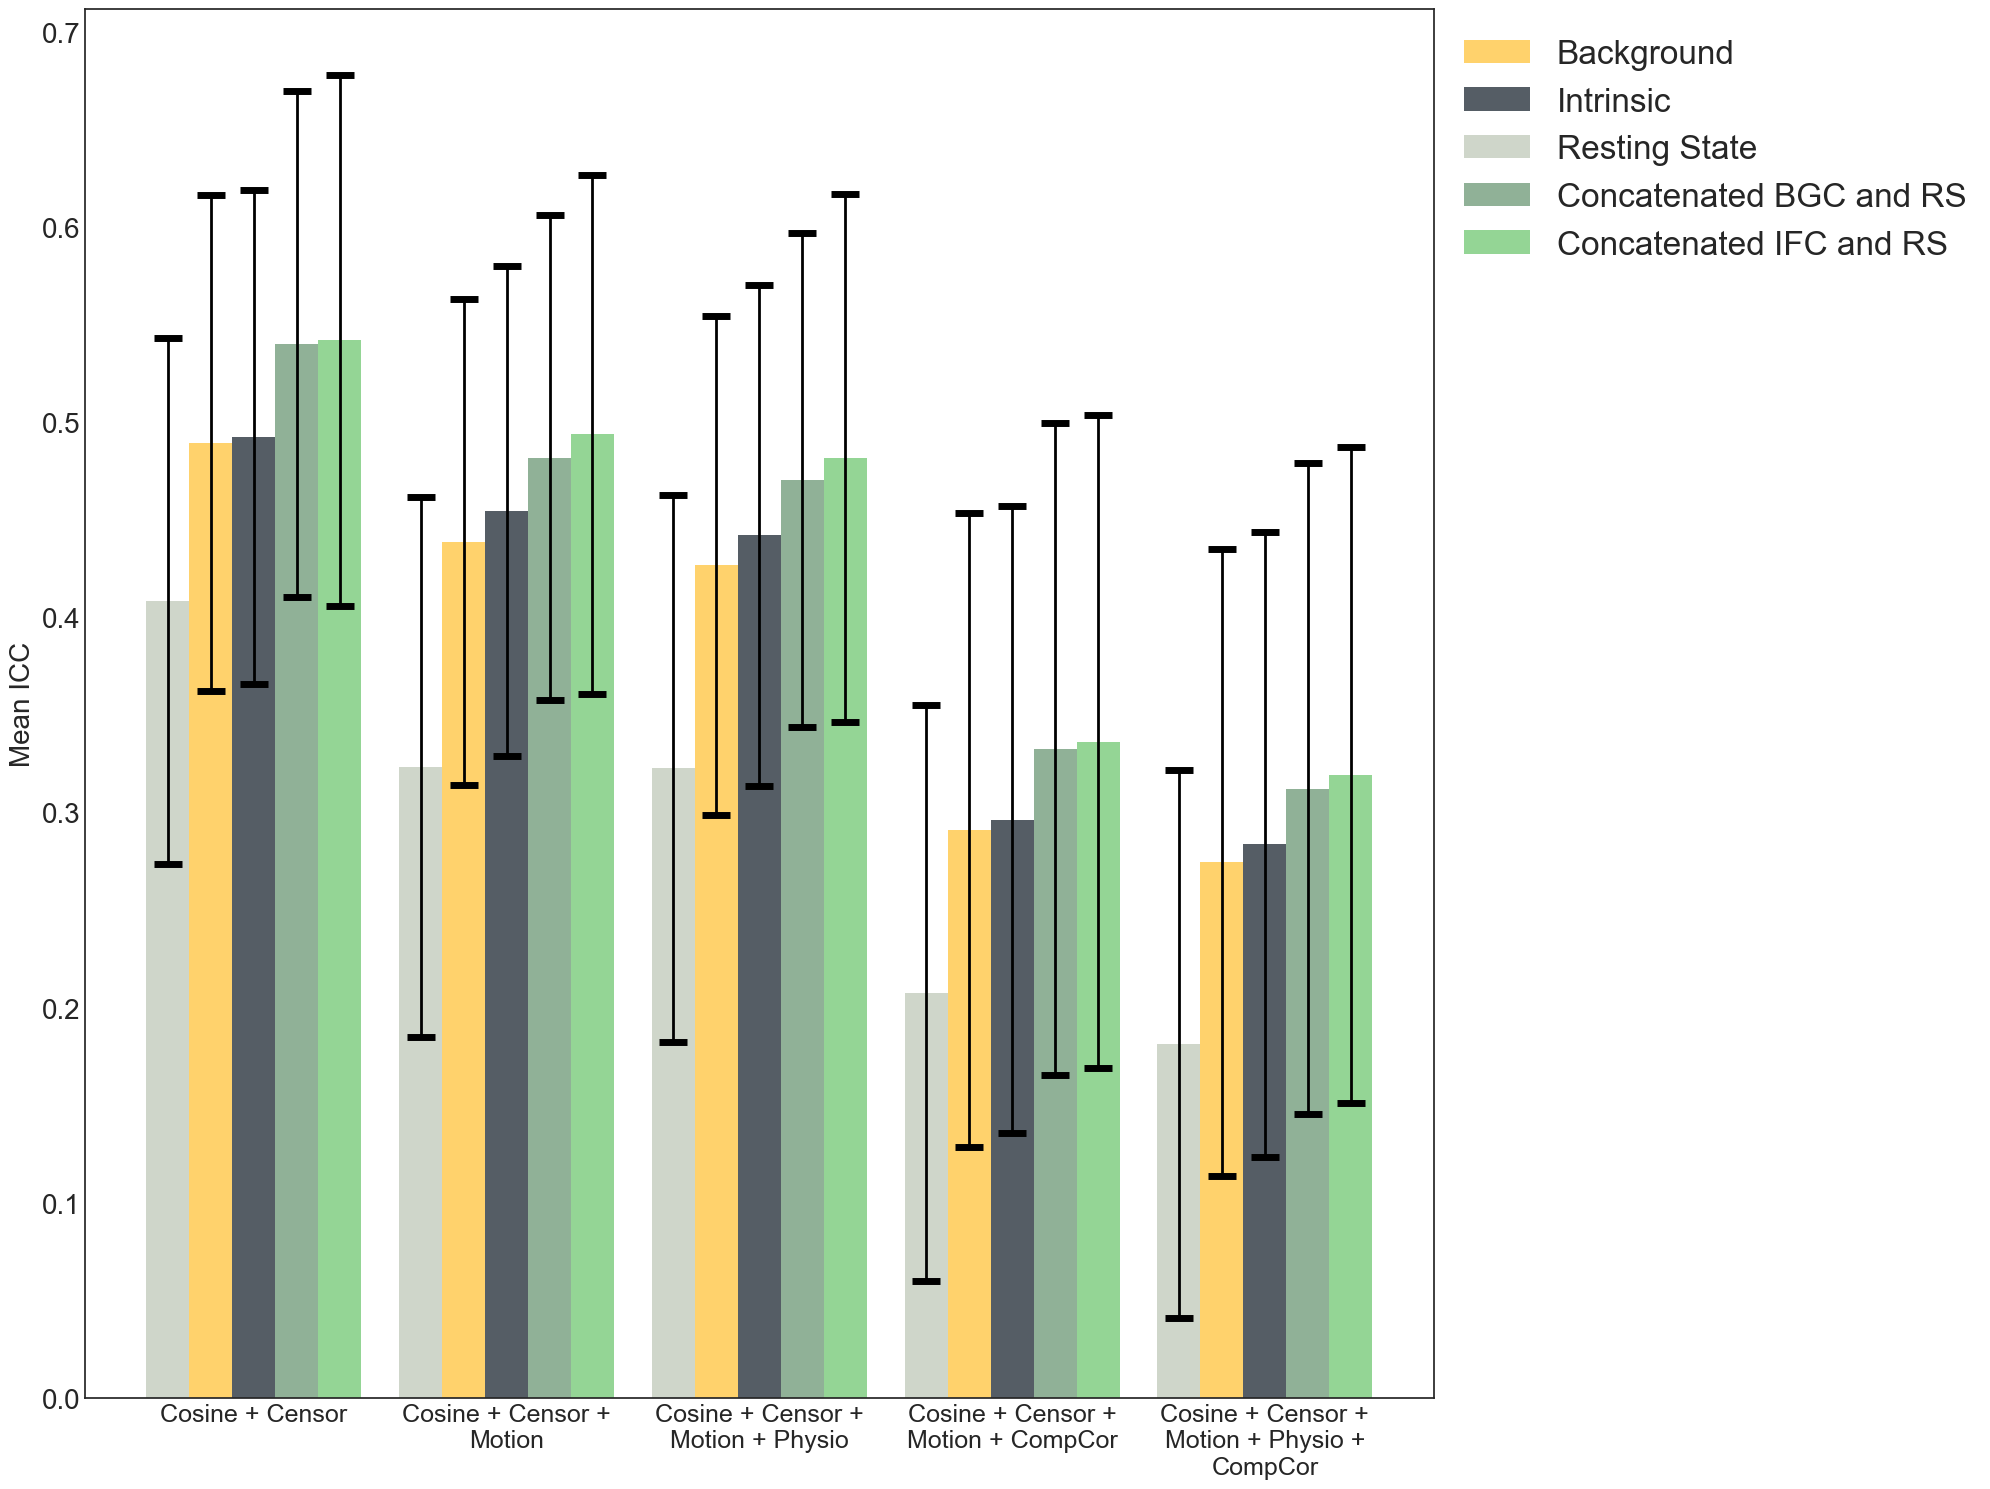

In [79]:
plt.style.use('default')
from textwrap import wrap
plt.style.use('seaborn-white')
n_groups = 5
means_bg = (m_bgc_cc,m_bgc_ccm,m_bgc_ccmp,m_bgc_ccmt,m_bgc_ccmpt)
means_if = (m_ifc_cc,m_ifc_ccm, m_ifc_ccmp,m_ifc_ccmt,m_ifc_ccmpt)
means_rs = (m_rs_cc,m_rs_ccm, m_rs_ccmp,m_rs_ccmt,m_rs_ccmpt)
means_cc = (m_concat_cc,m_concat_ccm, m_concat_ccmp,m_concat_ccmt,m_concat_ccmpt)
means_ccif = (m_concat_ifc_cc,m_concat_ifc_ccm, m_concat_ifc_ccmp,m_concat_ifc_ccmt,m_concat_ifc_ccmpt)

#plt.rcParams.update({'font.size': 10})

# create plot
fig, ax = plt.subplots(figsize=(20,15))
index = np.arange(n_groups)
bar_width = 0.17
opacity = .9
cap=10

plt.errorbar(index,means_bg, yerr=[s_bgc_cc,s_bgc_ccm,s_bgc_ccmp,s_bgc_ccmt,s_bgc_ccmpt], capsize=10, elinewidth=2, markeredgewidth=5,color='black',fmt='none')
plt.errorbar(index+bar_width,means_if, yerr=[s_ifc_cc,s_ifc_ccm,s_ifc_ccmp,s_ifc_ccmt,s_ifc_ccmpt], capsize=10, elinewidth=2, markeredgewidth=5,color='black',fmt='none')
plt.errorbar(index-bar_width,means_rs, yerr=[s_rs_cc,s_rs_ccm,s_rs_ccmp,s_rs_ccmt,s_rs_ccmpt], capsize=10, elinewidth=2, markeredgewidth=5,color='black',fmt='none')
plt.errorbar(index+(2*bar_width),means_cc, yerr=[s_concat_cc,s_concat_ccm,s_concat_ccmp,s_concat_ccmt,s_concat_ccmpt], capsize=10, elinewidth=2, markeredgewidth=5,color='black',fmt='none')
plt.errorbar(index+(3*bar_width),means_ccif, yerr=[s_concat_ifc_cc,s_concat_ifc_ccm,s_concat_ifc_ccmp,s_concat_ifc_ccmt,s_concat_ifc_ccmpt], capsize=10, elinewidth=2, markeredgewidth=5,color='black',fmt='none')
# plt.errorbar(index + (bar_width)+(bar_width*2),means_ccmpt, yerr=[s_bgc_ccmpt,0.162646], capsize=10, elinewidth=1.5, markeredgewidth=5,color='black',fmt='none')

rects1 = plt.bar(index,means_bg, bar_width,
alpha=opacity,color='#FFCE5C',align='center',
label='Background',capsize=20)

rects2 = plt.bar(index+bar_width, means_if, bar_width,
alpha=opacity,color='#424B54',align='center',
label='Intrinsic',capsize=cap)

rects3 = plt.bar(index - bar_width, means_rs, bar_width,
alpha=opacity,color='#CAD2C5',align='center',
label='Resting State',capsize=cap)

rects4 = plt.bar(index+(2*bar_width), means_cc, bar_width,
alpha=opacity,color='#84A98C',align='center',
label='Concatenated BGC and RS',capsize=cap)

rects4 = plt.bar(index+(3*bar_width), means_ccif, bar_width,
alpha=opacity,color='#88D18A',align='center',
label='Concatenated IFC and RS',capsize=cap)

# rects3 = plt.bar(index + bar_width, means_ccmt, bar_width,
# alpha=opacity,color='darkred',
# label='Cosine + Censor + Motion + CompCor',capsize=cap)

# rects4 = plt.bar(index + (bar_width*2), means_ccmpt, bar_width,
# alpha=opacity,color='maroon',
# label='Cosine + Censor + Motion + Physio + CompCor',capsize=cap)

# rects5 = plt.bar(index + (bar_width*3), means_ccmpt, bar_width,
# alpha=opacity,color='maroon',
# label='Cosine + Censor',capsize=cap)

plt.ylabel('Mean ICC',fontsize=20)
plt.yticks(fontsize=20)
labels = ['Cosine + Censor','Cosine + Censor + Motion','Cosine + Censor + Motion + Physio','Cosine + Censor + Motion + CompCor','Cosine + Censor + Motion + Physio + CompCor']
labels = [ '\n'.join(wrap(l, 20)) for l in labels ]
plt.xticks(index + bar_width, labels,wrap=True,fontsize=18)
plt.legend(bbox_to_anchor=(1, 1),fontsize=24)

plt.tight_layout()
plt.show()

In [24]:
# bgc = bs_res.loc[(bs_res.timeseries == 'bgc'), ['ICC','boot', 'measure', 'cfd']]
# ifc = bs_res.loc[(bs_res.timeseries == 'ifc'), ['ICC','boot', 'measure', 'cfd']]
# rs = bs_res.loc[(bs_res.timeseries == 'rs'), ['ICC','boot', 'measure', 'cfd']]
ts_df = rs.merge(ifc, how='outer', on=['boot', 'measure', 'cfd'], suffixes=['_rs', '_ifc'])
ts_df['diff'] = ts_df.ICC_rs - ts_df.ICC_ifc
boot_level_difs = ts_df.groupby(['boot', 'cfd']).mean().reset_index()
boot_level_difs.loc[:, 'diff'].quantile([0.05 / 16 / 2,0.05, 0.5, 0.975, 1 - (0.05 / 16 / 2)])

0.001563   -0.242175
0.050000   -0.179056
0.500000   -0.102004
0.975000   -0.028367
0.998437    0.023487
Name: diff, dtype: float64

In [23]:
ts_df = bgc.merge(rs, how='outer', on=['boot', 'measure', 'cfd'], suffixes=['_bgc', '_rs'])
ts_df['diff'] = ts_df.ICC_bgc - ts_df.ICC_rs
boot_level_difs = ts_df.groupby(['boot', 'cfd']).mean().reset_index()
boot_level_difs.loc[:, 'diff'].quantile([0.05 / 16 / 2,0.05, 0.5, 0.975, 1 - (0.05 / 16 / 2)])

0.001563   -0.024782
0.050000    0.036697
0.500000    0.092943
0.975000    0.178081
0.998437    0.216627
Name: diff, dtype: float64

In [ ]:
boot_level_difs.loc[:, 'diff'].quantile([0.05 / 16 / 2,0.05, 0.5, 0.975, 1 - (0.05 / 10 / 2)])

In [769]:
bgc_cc = bgc.loc[(bgc.cfd == 'cc.csv')]
bgc_ccm = bgc.loc[(bgc.cfd == 'ccm.csv')]
bgc_ccmp = bgc.loc[(bgc.cfd == 'ccmp.csv')]
bgc_ccmt = bgc.loc[(bgc.cfd == 'ccmt.csv')]
bgc_ccmpt = bgc.loc[(bgc.cfd == 'ccmpt.csv')]
ifc_cc = ifc.loc[(ifc.cfd == 'cc.csv')]
ifc_ccm = ifc.loc[(ifc.cfd == 'ccm.csv')]
ifc_ccmp = ifc.loc[(ifc.cfd == 'ccmp.csv')]
ifc_ccmt = ifc.loc[(ifc.cfd == 'ccmt.csv')]
ifc_ccmpt = ifc.loc[(ifc.cfd == 'ccmpt.csv')]

In [770]:
ts_df = ifc_ccmp.merge(ifc_ccmt,how='outer', on=['boot', 'measure'], suffixes=['_ccm', '_ccmpt'])
ts_df['diff'] = ts_df.ICC_ccm - ts_df.ICC_ccmpt
boot_level_difs = ts_df.groupby(['boot']).mean().reset_index()
boot_level_difs['diff'].quantile([0.05 / 10 / 2,.05, 0.5, 0.95, 1 - (0.05 / 10 / 2)])

0.0025    0.003465
0.0500    0.064241
0.5000    0.146559
0.9500    0.223571
0.9975    0.276112
Name: diff, dtype: float64

In [230]:
ts_df = ifc_ccm.merge(ifc_ccmp,how='outer', on=['boot', 'measure'], suffixes=['_ccm', '_ccmpt'])
ts_df['diff'] = ts_df.ICC_ccm - ts_df.ICC_ccmpt
boot_level_difs = ts_df.groupby(['boot']).mean().reset_index()
boot_level_difs['diff'].quantile([0.05 / 10 / 2,.05, 0.5, 0.95, 1 - (0.05 / 10 / 2)])

0.0025   -0.015525
0.0500   -0.003128
0.5000    0.012437
0.9500    0.028007
0.9975    0.040062
Name: diff, dtype: float64

In [235]:
ts_df = ifc_cc.merge(ifc_ccm,how='outer', on=['boot', 'measure'], suffixes=['_ccm', '_ccmpt'])
ts_df['diff'] = ts_df.ICC_ccm - ts_df.ICC_ccmpt
boot_level_difs = ts_df.groupby(['boot']).mean().reset_index()
boot_level_difs['diff'].quantile([0.05 / 10 / 2,.05, 0.5, 0.95, 1 - (0.05 / 10 / 2)])

0.0025   -0.042227
0.0500   -0.010946
0.5000    0.037018
0.9500    0.087792
0.9975    0.117385
Name: diff, dtype: float64

In [771]:
ts_df = bgc_cc.merge(bgc_ccmp,how='outer', on=['boot', 'measure'], suffixes=['_ccm', '_ccmpt'])
ts_df['diff'] = ts_df.ICC_ccm - ts_df.ICC_ccmpt
boot_level_difs = ts_df.groupby(['boot']).mean().reset_index()
boot_level_difs['diff'].quantile([0.05 / 10 / 2,.05, 0.5, 0.95, 1 - (0.05 / 10 / 2)])

0.0025   -0.018784
0.0500    0.011962
0.5000    0.062196
0.9500    0.115220
0.9975    0.151318
Name: diff, dtype: float64

In [237]:
ts_df = ifc_cc.merge(ifc_ccmt,how='outer', on=['boot', 'measure'], suffixes=['_ccm', '_ccmpt'])
ts_df['diff'] = ts_df.ICC_ccm - ts_df.ICC_ccmpt
boot_level_difs = ts_df.groupby(['boot']).mean().reset_index()
boot_level_difs['diff'].quantile([0.05 / 10 / 2,.05, 0.5, 0.95, 1 - (0.05 / 10 / 2)])

0.0025    0.082833
0.0500    0.133364
0.5000    0.196927
0.9500    0.258665
0.9975    0.292819
Name: diff, dtype: float64

In [238]:
ts_df = ifc_cc.merge(ifc_ccmpt,how='outer', on=['boot', 'measure'], suffixes=['_ccm', '_ccmpt'])
ts_df['diff'] = ts_df.ICC_ccm - ts_df.ICC_ccmpt
boot_level_difs = ts_df.groupby(['boot']).mean().reset_index()
boot_level_difs['diff'].quantile([0.05 / 10 / 2,.05, 0.5, 0.95, 1 - (0.05 / 10 / 2)])

0.0025    0.095110
0.0500    0.145760
0.5000    0.209993
0.9500    0.271139
0.9975    0.303993
Name: diff, dtype: float64

In [145]:
[cm_bgc_ccmt.append(pd.read_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices/bgc_cm_boot_{(bs_num):05d}_cfd_ccmt.csv',header=None).values) for bs_num in range(0,1001)]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [143]:
for bs_num in range(0,1001):
    cm_bgc_ccmt.append(pd.read_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices/bgc_cm_boot_{(bs_num):05d}_cfd_ccmt.csv',header=None).values)

KeyboardInterrupt: 

In [154]:
cmean_bgc_ccmt = []
for i in range(cm_bgc_ccmt[0].shape[0]):
    cmean_bgc_ccmt.append([])
    for j in range(cm_bgc_ccmt[0].shape[0]):
        cmean_bgc_ccmt[i].append(cm_bgc_ccmt[:][i][j].mean())

In [171]:
corr_dict = {}
def load_data(path):
    dat = pd.read_csv(path, header=None).values
    
    
    name_parts = path.as_posix().split("/")[-1].split('_')]
    corr_dict[f'{name_parts[0]}_{name_parts[-1]}'].append(dat)]
    corr_dict[f'{name_parts[0]}_{name_parts[-1]}'] = [dat]
bs_cor_dir = Path('/data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices/')
for ts in ['bgc','rs']:
    for cfd in cfd_dict:
    paths = sorted(bs_cor_dir.glob(f'{bgc}*{.csv'))
    corr_dict = Parallel(n_jobs=10, verbose=10)(delayed(load_data)(path) for path in paths)
# bs_cors = [load_data(path) for path in paths]
cmean_bgc_ccmt = []
for x in corr_dict:
    for i in range(corr_dict[x][0].shape[0]):
        for j in range(corr_dict[x][0].shape[1]):
            corr_dict[x][0][i][j] = corr_dict[x][:][i][j].mean()

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1873s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Batch computation too fast (0.0518s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  96 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Batch computation too fast (0.0977s.) Setting batch_size=8.
[Parallel(n_jobs=10)]: Done 152 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done 244 tasks      | elapsed:    4.3s
[Parallel(n_jobs=10)]: Done 380 tasks      | elapsed: 

In [378]:
corr_dict = {}
bs_cor_dir = Path('/data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices/')
for ts in ['bgc','ifc']:
    for x in cfd_dict:
        cfd = cfd_dict[x]
        paths = sorted(bs_cor_dir.glob(f'{ts}*{cfd}.csv'))
        corr_dict[f'{ts}_{cfd}'] = np.zeros(((1001,64,64)))
        np.array(pd.read_csv(paths[0],index_col=0))
        for i in range(0,1001):
            corr_dict[f'{ts}_{cfd}'][i] = pd.read_csv(paths[i],header=None).values
        #pd.DataFrame(corr_dict[f'{ts}_{cfd}'][0]).to_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/ave_matrices/cm_ave_{ts}_{cfd}.csv')

In [7]:
corr_dict = {}
bs_cor_dir = Path('/data/MBDU/midla/notebooks/campcc/test_retest/bootstrapped_matrices/')
for ts in ['rs']:
    for x in cfd_dict:
        cfd = cfd_dict[x]
        paths = sorted(bs_cor_dir.glob(f'{ts}*{cfd}.csv'))
        corr_dict[f'{ts}_{cfd}'] = np.zeros(((1001,64,64)))
        np.array(pd.read_csv(paths[0],index_col=0))
        for i in range(0,1001):
            corr_dict[f'{ts}_{cfd}'][i] = pd.read_csv(paths[i],header=None).values
        #pd.DataFrame(corr_dict[f'{ts}_{cfd}'][0]).to_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/ave_matrices/cm_ave_{ts}_{cfd}.csv')

In [8]:
for ts in ['rs']:
    for x in cfd_dict:
        cfd = cfd_dict[x]
        pd.DataFrame(np.mean(corr_dict[f'{ts}_{cfd}'],axis=0)).to_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/ave_matrices/cm_ave_{ts}_{cfd}.csv',index=None)

In [386]:
pd.read_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/ave_matrices/cm_ave_{ts}_{cfd}.csv').shape

(64, 64)

In [299]:
# cfd = cfd_dict[4]
# ts = 'bgc'
# paths = sorted(bs_cor_dir.glob(f'{ts}*{cfd}.csv'))
# corr_dict[f'{ts}_{cfd}'][0] = [pd.read_csv(paths[0],header=None).values]
# for i in range(0,1001):
#     corr_dict[f'{ts}_{cfd}'].append(pd.read_csv(paths[i],header=None).values)
# for j in range(0,corr_dict[f'{ts}_{cfd}'][0].shape[0]):
#     for k in range(0,corr_dict[f'{ts}_{cfd}'][0].shape[1]):
#         corr_dict[f'{ts}_{cfd}'][0][j][k] = corr_dict[f'{ts}_{cfd}'][:][j][k].mean()

In [737]:
df = np.zeros((64,64))
for i in range(64):
    for j in range(64):
        if i > j:
            df[i][j] = means['ICC','mean'].loc[means['measure_x'] == i].loc[means['measure_y'] == j].loc[f'{ts}',f'{cfd}.csv'][0]
df = pd.DataFrame(df)

In [9]:
ts = 'rs'
cfd = 'ccmp'

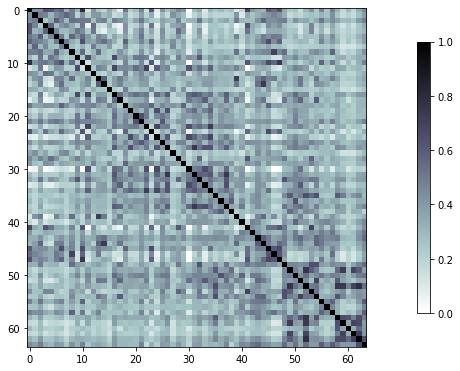

In [10]:
plotting.plot_matrix(pd.read_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/ave_matrices/cm_ave_{ts}_{cfd}.csv'),cmap='bone_r',vmax=1,vmin=0)

In [785]:
for ts in ['ifc']:
    cfd = 'ccmp'
    df = np.zeros((64,64))
    for i in range(64):
        for j in range(i):
            df[i][j] = means['ICC','mean'].loc[means['measure_x'] == i].loc[means['measure_y'] == j].loc[f'{ts}',f'{cfd}.csv'][0]
df

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.41657819, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.38062955, 0.42910949, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.30310554, 0.39013258, 0.35431631, ..., 0.        , 0.        ,
        0.        ],
       [0.35121499, 0.49868147, 0.45320976, ..., 0.27917695, 0.        ,
        0.        ],
       [0.38877461, 0.40766729, 0.38864482, ..., 0.30079446, 0.48857728,
        0.        ]])

In [784]:
df

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.40000941, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.35776984, 0.41172664, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.28946324, 0.34288607, 0.34024186, ..., 0.        , 0.        ,
        0.        ],
       [0.341729  , 0.46855883, 0.42663364, ..., 0.286256  , 0.        ,
        0.        ],
       [0.40246544, 0.41349138, 0.33091992, ..., 0.33193737, 0.46392487,
        0.        ]])

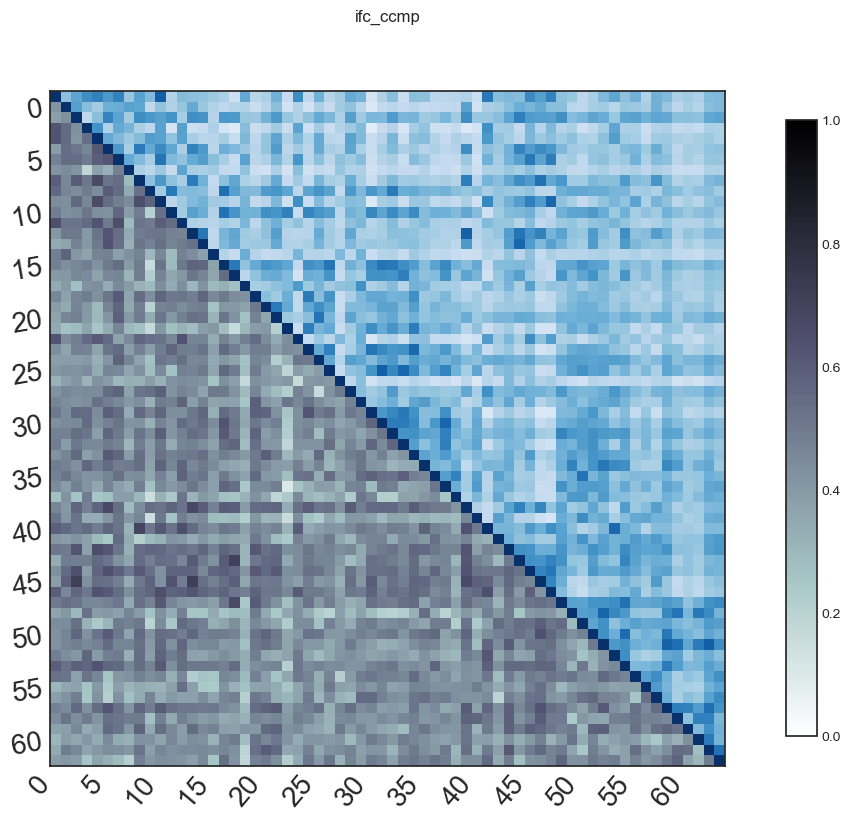

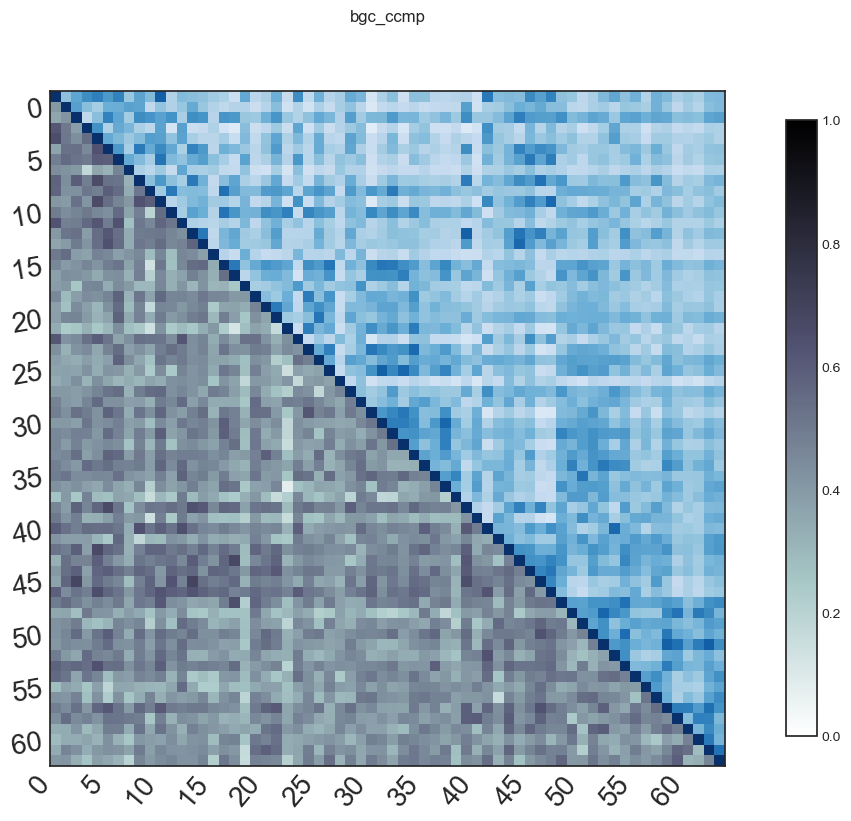

In [773]:
for ts in ['ifc','bgc']:
    cfd = 'ccmp'
    df = np.zeros((64,64))
    for i in range(64):
        for j in range(i):
            df[i][j] = means['ICC','mean'].loc[means['measure_x'] == i].loc[means['measure_y'] == j].loc[f'{ts}',f'{cfd}.csv'][0]

    mat = pd.read_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/ave_matrices/cm_ave_{ts}_{cfd}.csv')
    fig,ax = plt.subplots(1,figsize = (10,10))
    plotting.plot_matrix(mat, tri='upper',figure = fig,labels=labels,cmap = 'Blues',vmin = 0,vmax = 1,colorbar = False)
    plotting.plot_matrix(df, figure = fig,tri='lower',labels=labels,cmap = 'bone_r',vmax = 1,vmin=0,colorbar = True,grid=False)

    plt.xticks(np.arange(0,ave.shape[0],5),fontsize=20)
    ax.set_xticklabels(np.arange(0,ave.shape[0],5),fontsize=20)
    plt.yticks(np.arange(0,ave.shape[1],5),fontsize=20)
    ax.set_yticklabels(np.arange(0,ave.shape[1],5),fontsize=20)
    plt.title(f'{ts}_{cfd}',pad=50)
    fig.patch.set_facecolor('white')

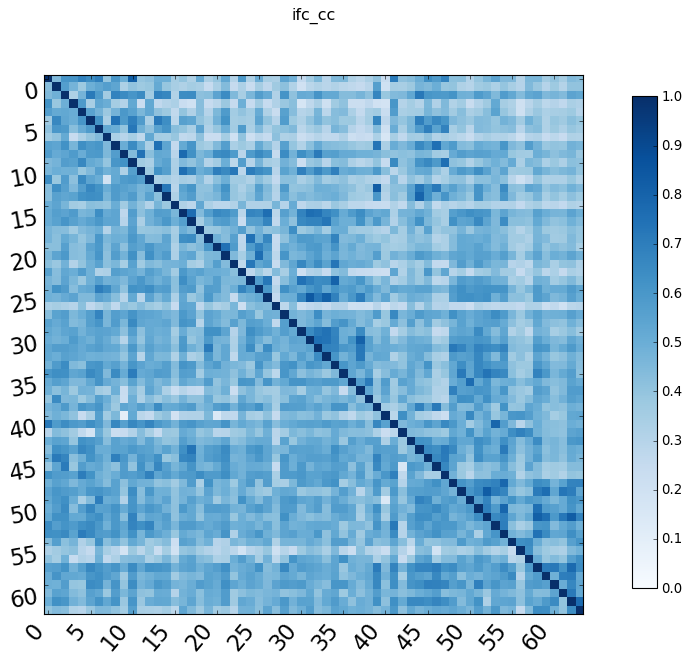

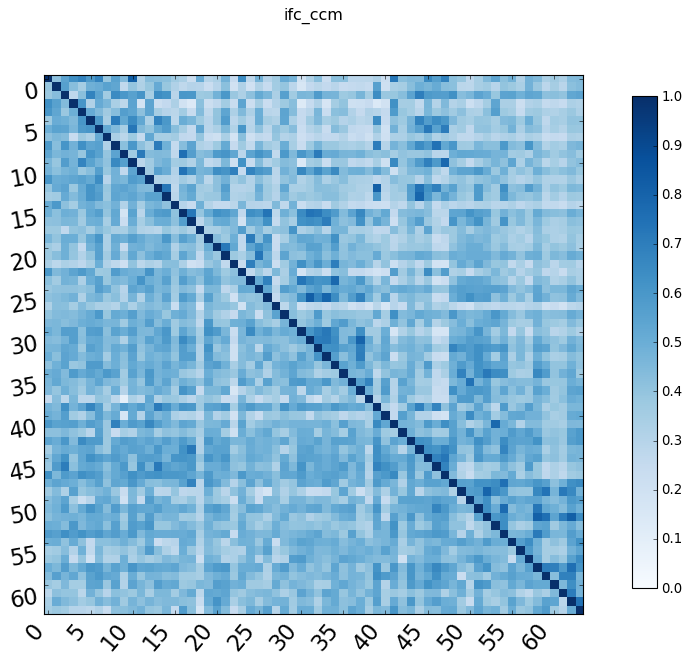

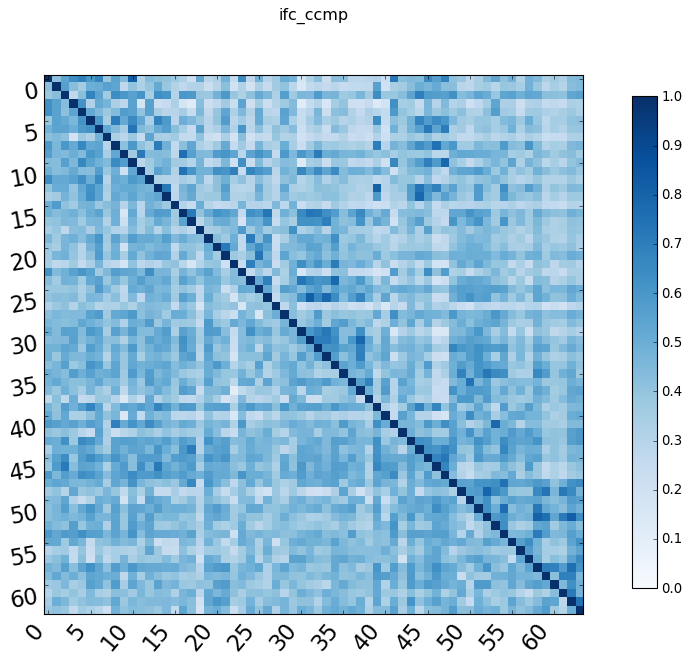

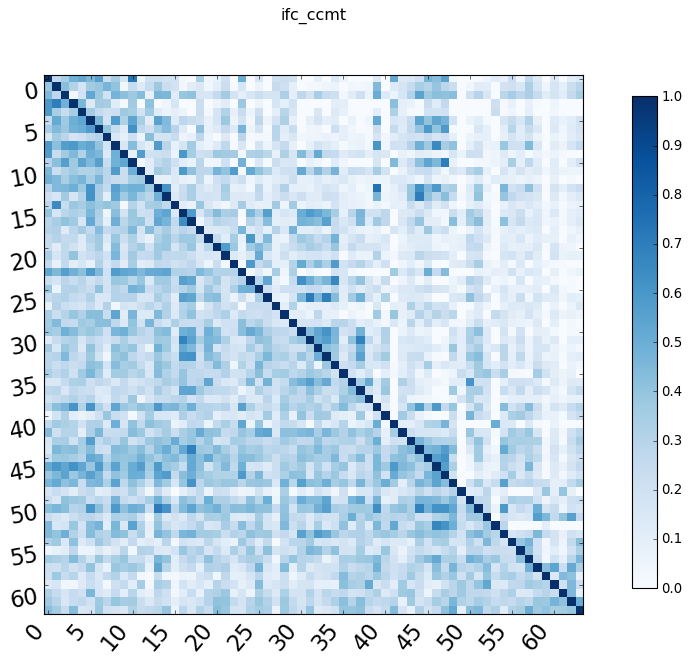

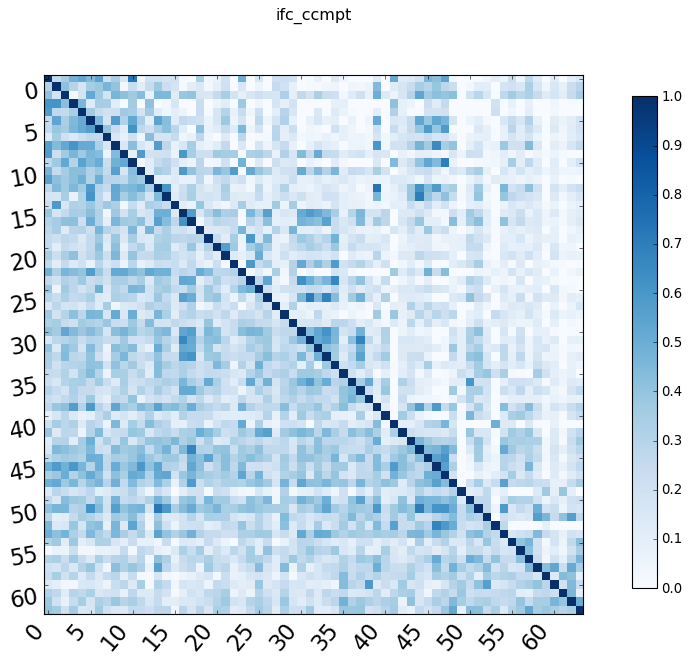

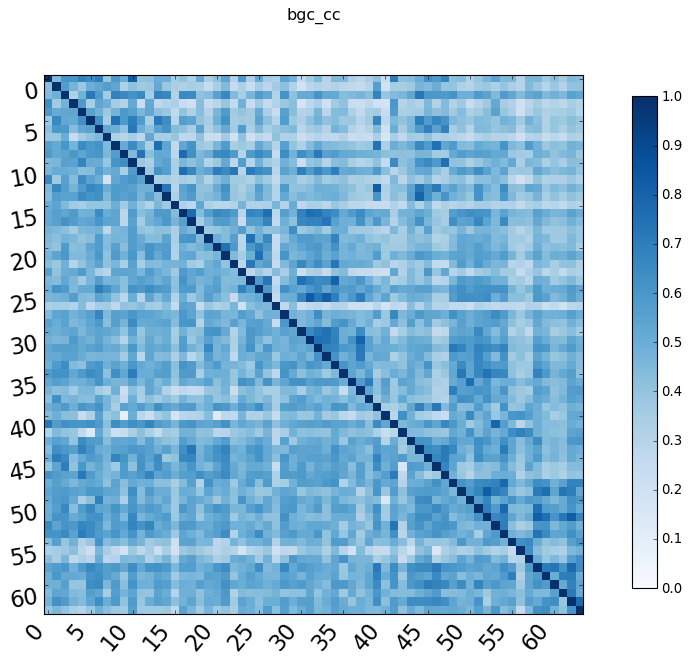

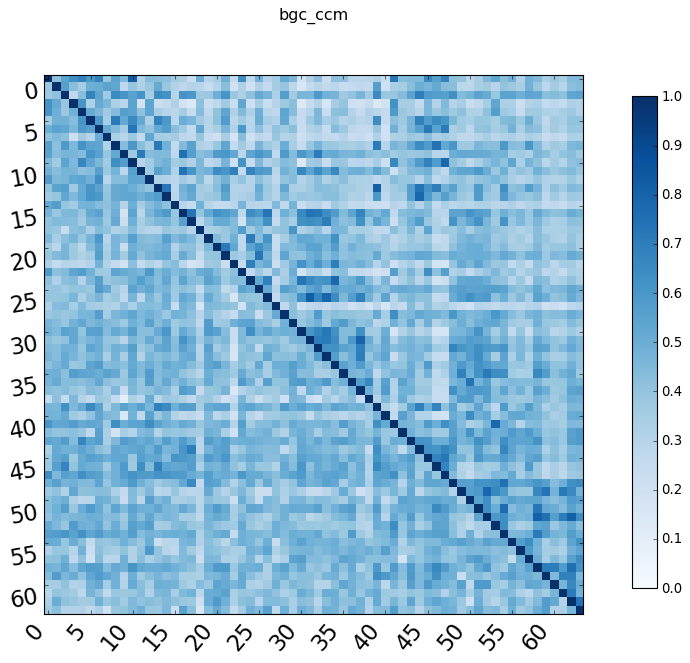

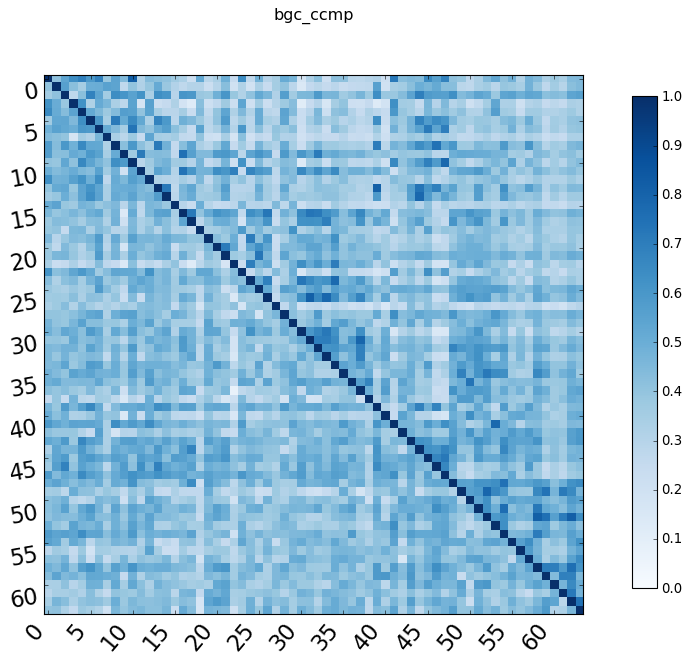

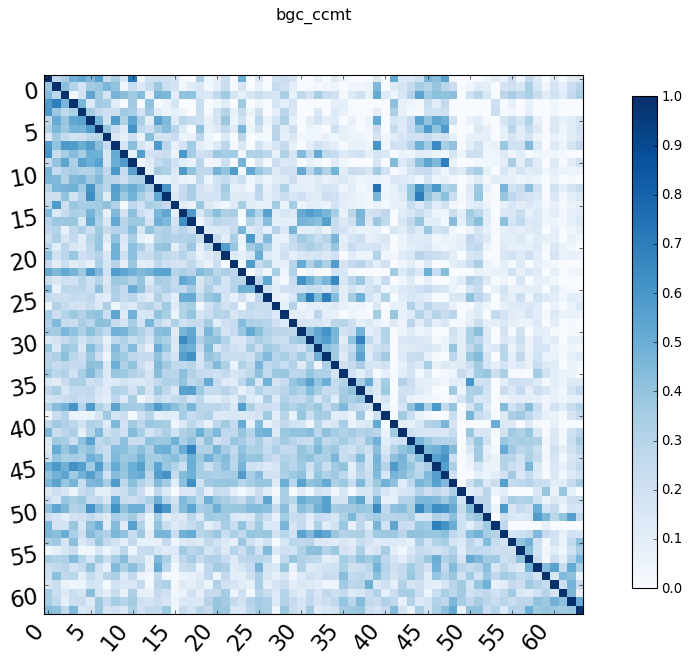

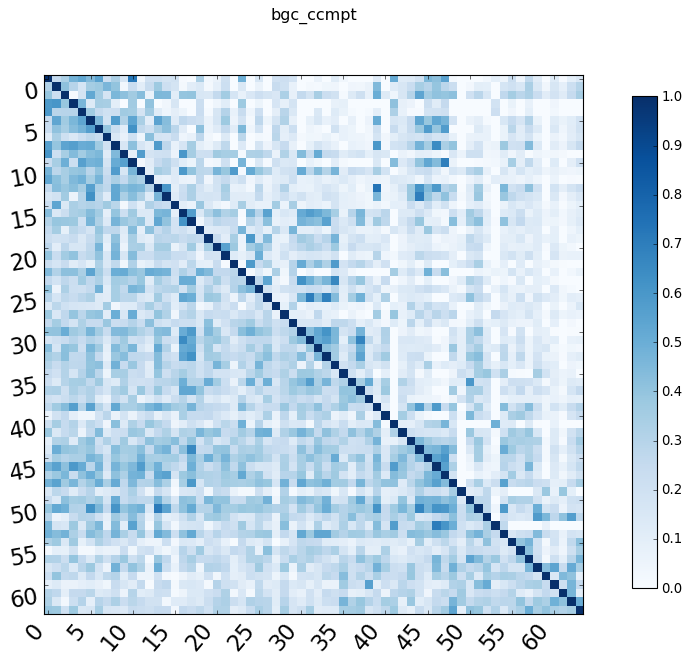

In [740]:
style.use('classic')
for ts in ['ifc','bgc']:
    for cfd in cfd_dict.values():
        df = np.zeros((64,64))
        for i in range(64):
            for j in range(i):
                df[i][j] = means['ICC','mean'].loc[means['measure_x'] == i].loc[means['measure_y'] == j].loc[f'{ts}',f'{cfd}.csv'][0]
        df = pd.DataFrame(df)
        mat = pd.read_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/ave_matrices/cm_ave_{ts}_{cfd}.csv')
        fig,ax = plt.subplots(1,figsize = (10,10))
        plotting.plot_matrix(mat, tri='upper',figure = fig,labels=labels,cmap = 'Blues',vmin = 0,vmax = 1,colorbar = True)
        plotting.plot_matrix(df, figure = fig,tri='lower',labels=labels,cmap = 'YlOrRd',vmax = 1,vmin=0,colorbar = False,grid=False)
        
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='verticle')
        cb1.set_label('Some Units')
        fig.show()

        plt.xticks(np.arange(0,ave.shape[0],5),fontsize=20)
        ax.set_xticklabels(np.arange(0,ave.shape[0],5),fontsize=20)
        plt.yticks(np.arange(0,ave.shape[1],5),fontsize=20)
        ax.set_yticklabels(np.arange(0,ave.shape[1],5),fontsize=20)
        plt.title(f'{ts}_{cfd}',pad=50)
        fig.patch.set_facecolor('white')

In [389]:
#ifc = bs_res.loc[(bs_res.timeseries == 'bgc'), ['ICC','boot', 'measure', 'cfd']]
measure_ifc = ifc.groupby(['measure']).mean().reset_index()
measure_bgc = bgc.groupby(['measure']).mean().reset_index()

In [433]:
bgc_cc = bgc.loc[(bgc.cfd == 'cc.csv')]
bgc_cc = bgc_cc.groupby(['measure']).mean().reset_index()
bgc_ccm = bgc.loc[(bgc.cfd == 'ccm.csv')]
bgc_ccm = bgc_ccm.groupby(['measure']).mean().reset_index()
bgc_ccmp = bgc.loc[(bgc.cfd == 'ccmp.csv')]
bgc_ccmp = bgc_ccmp.groupby(['measure']).mean().reset_index()
bgc_ccmt = bgc.loc[(bgc.cfd == 'ccmt.csv')]
bgc_ccmt = bgc_ccmt.groupby(['measure']).mean().reset_index()
bgc_ccmpt = bgc.loc[(bgc.cfd == 'ccmpt.csv')]
bgc_ccmpt = bgc_ccmpt.groupby(['measure']).mean().reset_index()

In [434]:
ifc_cc = ifc.loc[(ifc.cfd == 'cc.csv')]
ifc_cc = ifc_cc.groupby(['measure']).mean().reset_index()
ifc_ccm = ifc.loc[(ifc.cfd == 'ccm.csv')]
ifc_ccm = ifc_ccm.groupby(['measure']).mean().reset_index()
ifc_ccmp = ifc.loc[(ifc.cfd == 'ccmp.csv')]
ifc_ccmp = ifc_ccmp.groupby(['measure']).mean().reset_index()
ifc_ccmt = ifc.loc[(ifc.cfd == 'ccmt.csv')]
ifc_ccmt = ifc_ccmt.groupby(['measure']).mean().reset_index()
ifc_ccmpt = ifc.loc[(ifc.cfd == 'ccmpt.csv')]
ifc_ccmpt = ifc_ccmpt.groupby(['measure']).mean().reset_index()

In [452]:
means = bs_res.groupby(['timeseries',  'cfd','measure'])[['ICC']].mean().reset_index().groupby(['timeseries', 'cfd','measure']).agg(['mean', 'std', 'count'])

In [457]:
means.loc['bgc','cc.csv'].index

Index(['10_0', '10_1', '10_2', '10_3', '10_4', '10_5', '10_6', '10_7', '10_8', '10_9',
       ...
       '8_7', '9_0', '9_1', '9_2', '9_3', '9_4', '9_5', '9_6', '9_7', '9_8'], dtype='object', name='measure', length=2016)

In [ ]:
rng = np.random.RandomState(0)
x = rng.randn(100)
y = rng.randn(100)
colors = rng.rand(100)
sizes = 1000 * rng.rand(100)

plt.scatter(x, y, c=colors, s=sizes, alpha=0.3,
            cmap='viridis')
plt.colorbar();  # show color scale

In [ ]:
def split(i):
    return means_in.loc[i,'measure'].values[0].split('_')

splits = Parallel(n_jobs=10, verbose=10)(delayed(split)(i) for i in range(len(means_in)))
x,y = zip(*[(int(i[0]),int(i[1])) for i in splits])

means['measure_x'] = x
means['measure_y'] = y

In [501]:
means = means.sort_values(['timeseries','cfd','measure_x','measure_y'])

In [570]:
ind = np.tril_indices(len(pd.read_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/ave_matrices/cm_ave_{ts}_{cfd}.csv')),k=-1)

In [557]:
ind

(array([ 0,  0,  1, ..., 63, 63, 63]), array([ 0,  1,  0, ..., 61, 62, 63]))

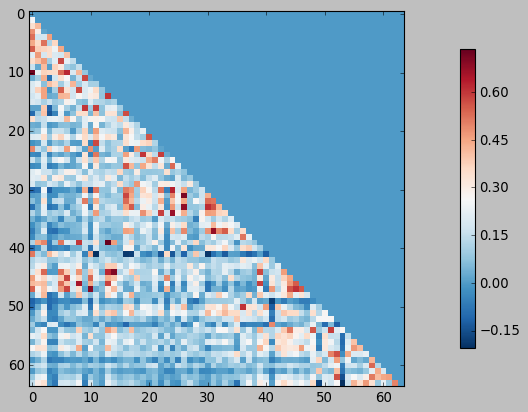

In [569]:
plotting.plot_matrix(np.tril(np.array(pd.read_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/ave_matrices/cm_ave_{ts}_{cfd}.csv')),k=-1))

In [602]:
np.arange(0,len(means.loc['bgc','cc.csv']))

array([   0,    1,    2, ..., 2013, 2014, 2015])

In [632]:
x

[(1, 0),
 (2, 0),
 (2, 1),
 (3, 0),
 (3, 1),
 (3, 2),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (8, 0),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (9, 0),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (10, 0),
 (10, 1),
 (10, 2),
 (10, 3),
 (10, 4),
 (10, 5),
 (10, 6),
 (10, 7),
 (10, 8),
 (10, 9),
 (11, 0),
 (11, 1),
 (11, 2),
 (11, 3),
 (11, 4),
 (11, 5),
 (11, 6),
 (11, 7),
 (11, 8),
 (11, 9),
 (11, 10),
 (12, 0),
 (12, 1),
 (12, 2),
 (12, 3),
 (12, 4),
 (12, 5),
 (12, 6),
 (12, 7),
 (12, 8),
 (12, 9),
 (12, 10),
 (12, 11),
 (13, 0),
 (13, 1),
 (13, 2),
 (13, 3),
 (13, 4),
 (13, 5),
 (13, 6),
 (13, 7),
 (13, 8),
 (13, 9),
 (13, 10),
 (13, 11),
 (13, 12),
 (14, 0),
 (14, 1),
 (14, 2),
 (14, 3),
 (14, 4),
 (14, 5),
 (14, 6),
 (14, 7),
 (14, 8),
 (14, 9),
 (14, 10),
 (14, 11),
 (14, 1

In [652]:
x[::100]

[(1, 0),
 (14, 9),
 (20, 10),
 (25, 0),
 (28, 22),
 (32, 4),
 (35, 5),
 (37, 34),
 (40, 20),
 (42, 39),
 (45, 10),
 (47, 19),
 (49, 24),
 (51, 25),
 (53, 22),
 (55, 15),
 (57, 4),
 (58, 47),
 (60, 30),
 (62, 9),
 (63, 47)]

In [711]:
means

ICC           measure_x measure_y
                                 mean std count                    
timeseries cfd      measure                                        
bgc        cc.csv   1_0      0.423408 NaN     1         1         0
                    2_0      0.439615 NaN     1         2         0
                    2_1      0.489558 NaN     1         2         1
                    3_0      0.629892 NaN     1         3         0
                    3_1      0.365465 NaN     1         3         1
                    3_2      0.476777 NaN     1         3         2
                    4_0      0.586326 NaN     1         4         0
                    4_1      0.508706 NaN     1         4         1
                    4_2      0.531934 NaN     1         4         2
                    4_3      0.532931 NaN     1         4         3
                    5_0      0.369780 NaN     1         5         0
                    5_1      0.657484 NaN     1         5         1
                    5_2      0.524721 NaN     1         5         2
                    5_3      0.518465 NaN     1         5         3
                    5_4      0.630086 NaN     1         5         4
                    6_0      0.419679 NaN     1         6         0
                    6_1      0.594224 NaN     1         6         1
                    6_2      0.593066 NaN     1         6         2
                    6_3      0.435571 NaN     1         6         3
                    6_4      0.528392 NaN     1         6         4
                    6_5      0.547613 NaN     1         6         5
                    7_0      0.379915 NaN     1         7         0
                    7_1      0.388366 NaN     1         7         1
                    7_2      0.507607 NaN     1         7         2
                    7_3      0.247269 NaN     1         7         3
                    7_4      0.358181 NaN     1         7         4
                    7_5      0.408134 NaN     1         7         5
                    7_6      0.449874 NaN     1         7         6
                    8_0      0.560248 NaN     1         8         0
                    8_1      0.522908 NaN     1         8         1
                    8_2      0.603033 NaN     1         8         2
                    8_3      0.476196 NaN     1         8         3
                    8_4      0.647118 NaN     1         8         4
                    8_5      0.596331 NaN     1         8         5
                    8_6      0.615526 NaN     1         8         6
                    8_7      0.444906 NaN     1         8         7
                    9_0      0.593213 NaN     1         9         0
                    9_1      0.521334 NaN     1         9         1
                    9_2      0.541962 NaN     1         9         2
                    9_3      0.596771 NaN     1         9         3
                    9_4      0.540603 NaN     1         9         4
                    9_5      0.595953 NaN     1         9         5
                    9_6      0.602221 NaN     1         9         6
                    9_7      0.458457 NaN     1         9         7
                    9_8      0.571151 NaN     1         9         8
                    10_0     0.446257 NaN     1        10         0
                    10_1     0.461006 NaN     1        10         1
                    10_2     0.554953 NaN     1        10         2
                    10_3     0.550090 NaN     1        10         3
                    10_4     0.673870 NaN     1        10         4
                    10_5     0.511466 NaN     1        10         5
                    10_6     0.505882 NaN     1        10         6
                    10_7     0.393227 NaN     1        10         7
                    10_8     0.612182 NaN     1        10         8
                    10_9     0.633858 NaN     1        10         9
                    11_0     0.468440 NaN     1        11         0
                    11

In [668]:
len(corr)

2016

In [705]:
cfd_dict.values()

TypeError: 'dict_values' object is not subscriptable

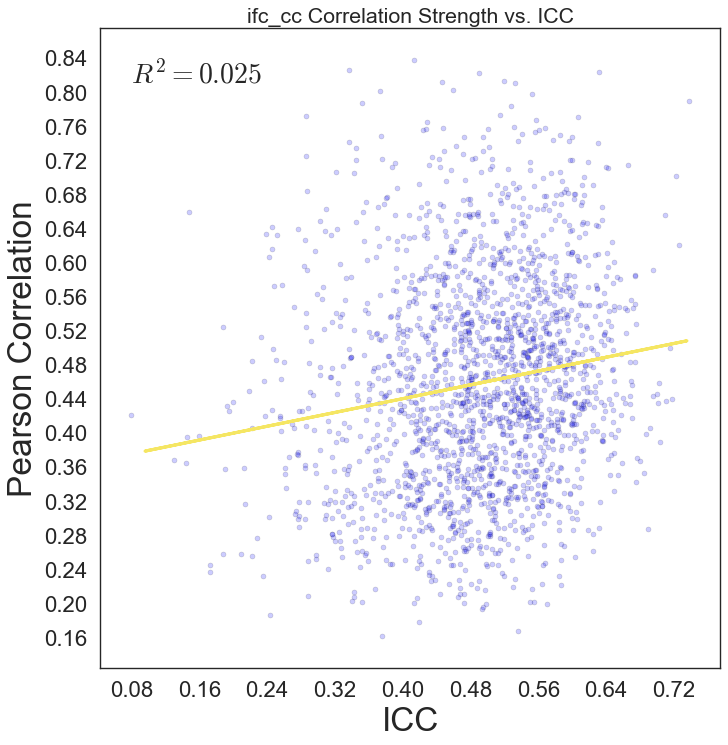

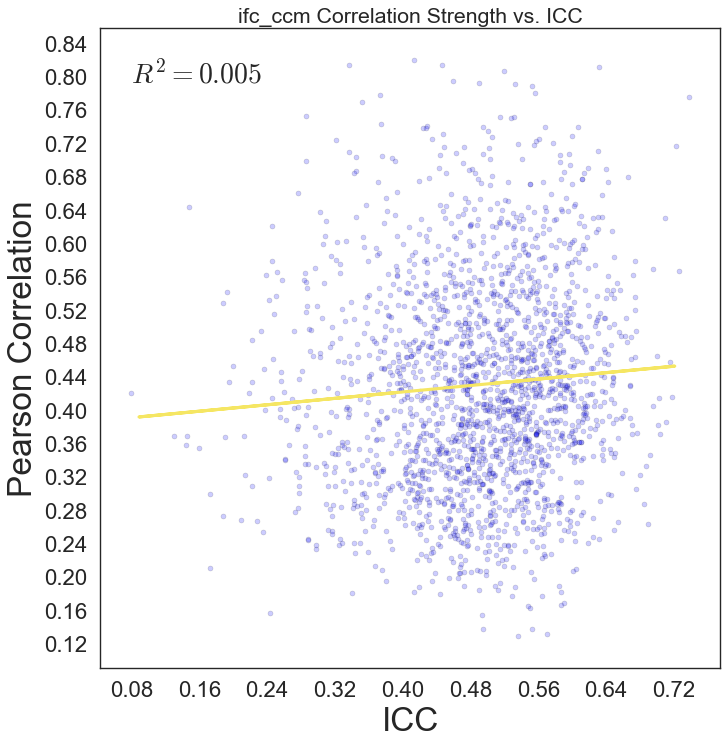

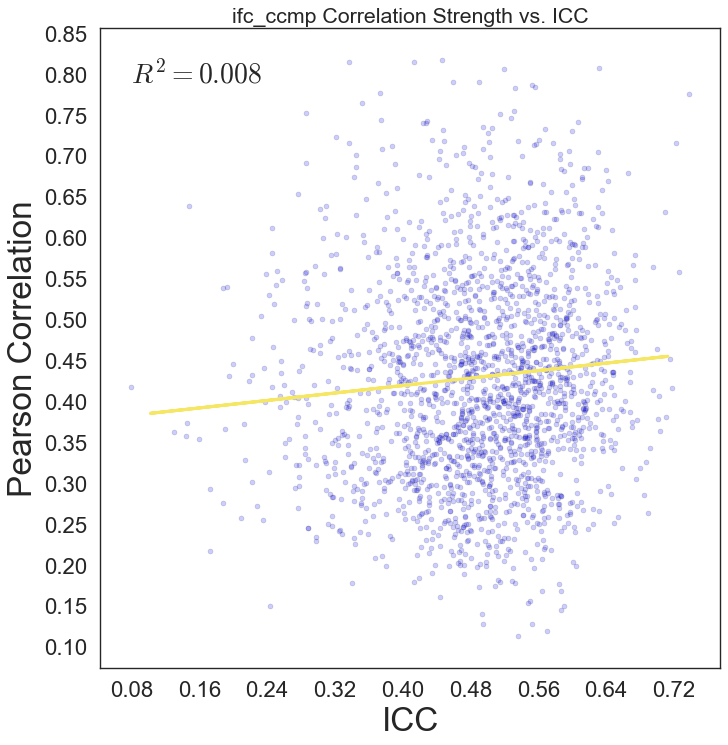

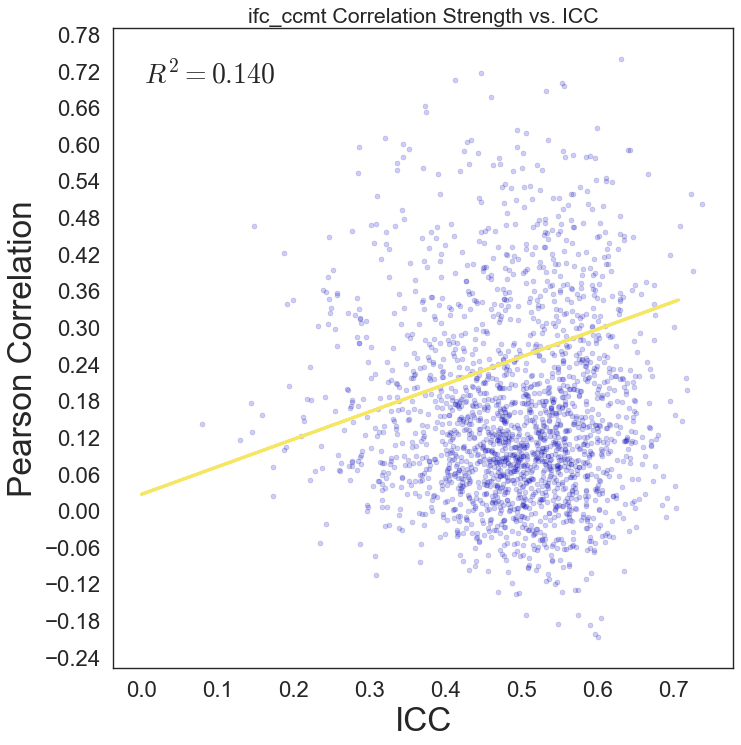

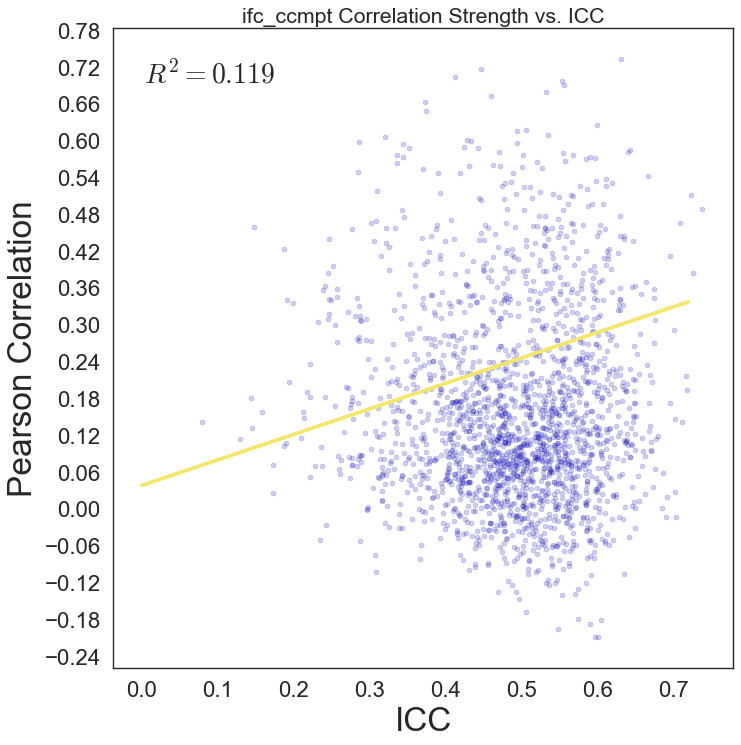

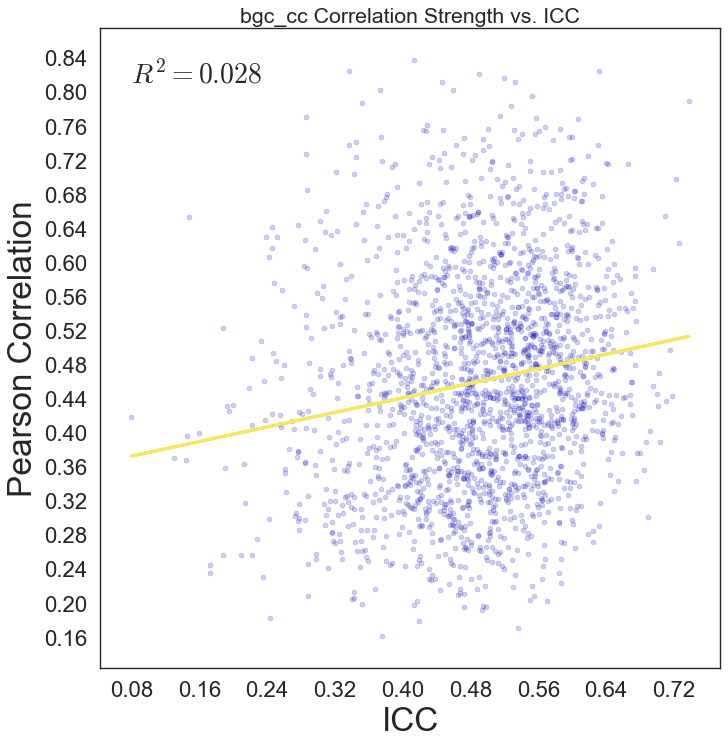

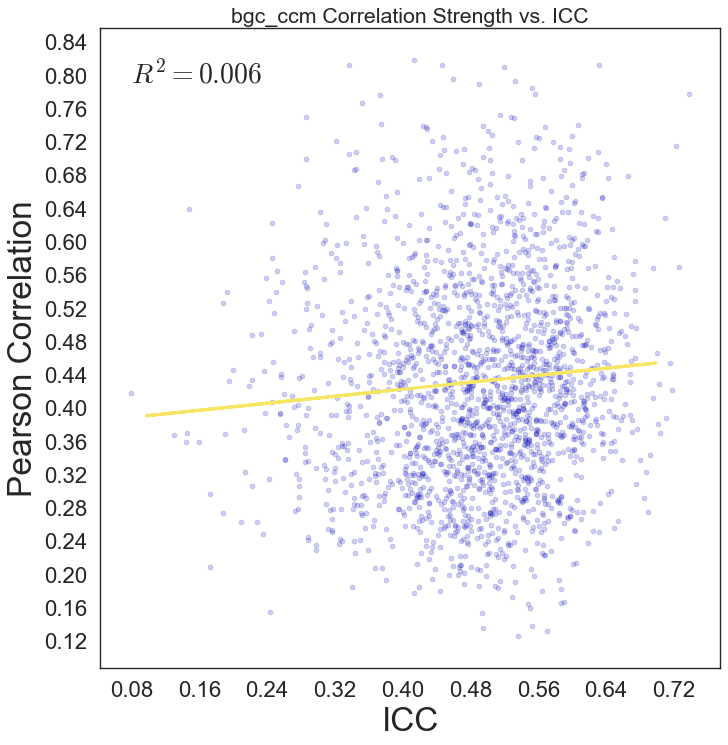

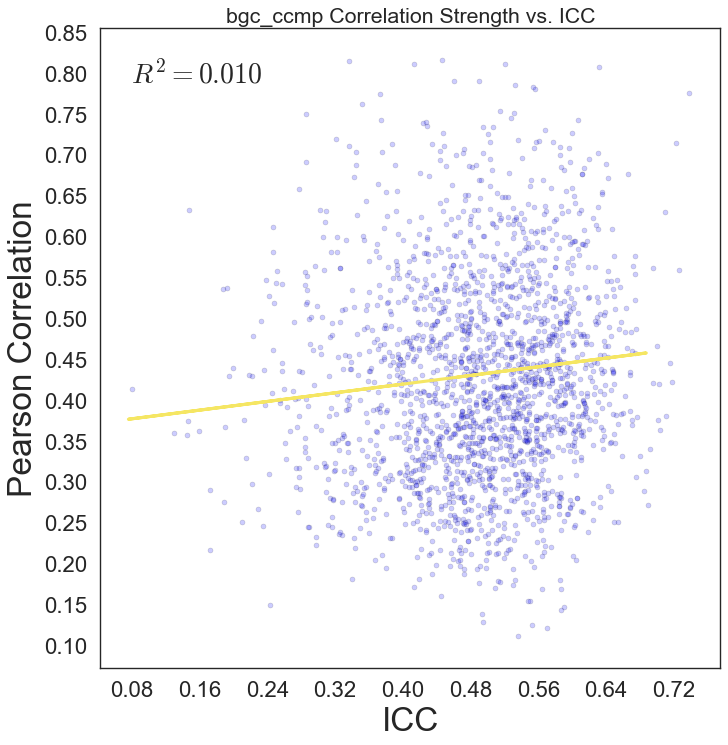

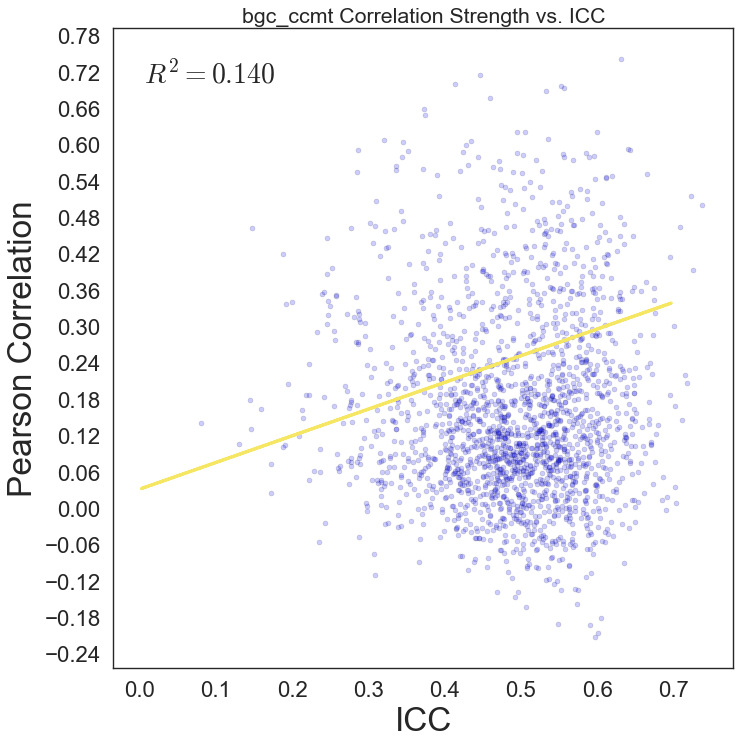

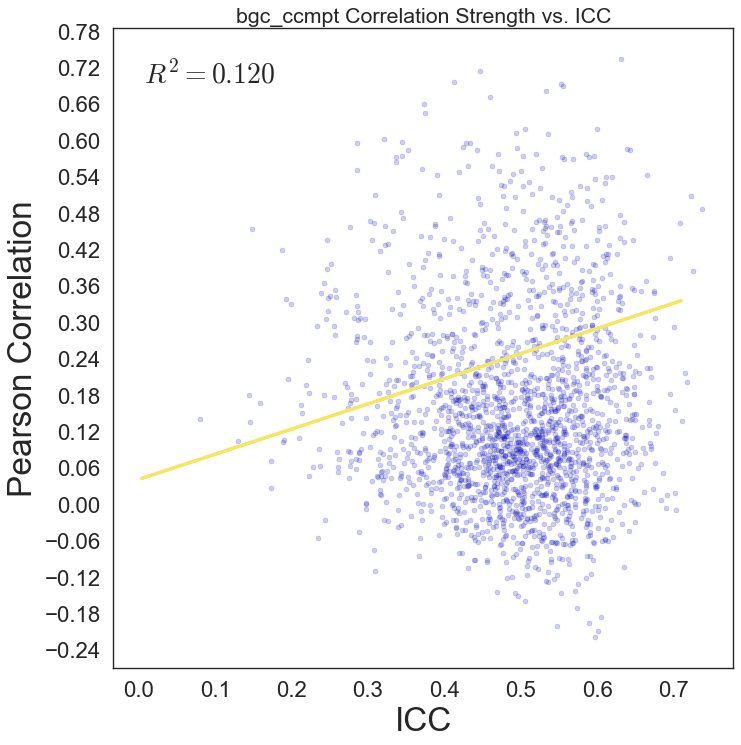

In [704]:
from sklearn.metrics import r2_score
style.use('seaborn-poster')

for ts in ['ifc','bgc']:
    for cfd in ['cc']:
        x=means.loc[f'{ts}',f'{cfd}.csv'].reset_index()['ICC','mean']
        corr = np.array(pd.read_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/ave_matrices/cm_ave_{ts}_{cfd}.csv'))[ind]
        ind = np.tril_indices(len(pd.read_csv(f'/data/MBDU/midla/notebooks/campcc/test_retest/ave_matrices/cm_ave_{ts}_{cfd}.csv')),k=-1)
        xtick = list(zip(means.loc[f'{ts}',f'{cfd}.csv'][['measure_x']].measure_x,means.loc[f'{ts}',f'{cfd}.csv'][['measure_y']].measure_y))
        fig,ax = plt.subplots(1,figsize = (10,10))

        plt.scatter(means.loc['bgc','cc.csv'].reset_index()['ICC','mean'], corr, alpha=0.2, cmap='Blues')

        plt.xticks(means.loc['bgc','cc.csv'].reset_index()['ICC','mean'],fontsize=20)
        plt.xlabel('ICC',fontsize=30)
        plt.yticks(corr,fontsize=20)
        z = np.polyfit(x, corr, 1)
        p = np.poly1d(z)(x)
        plt.plot(x,p,color='#f5e663')
        text = f'$R^2 = {r2_score(corr,p):0.3f}$'
        plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
             fontsize=25, verticalalignment='top')

        ax.xaxis.set_major_locator(plt.MaxNLocator(10))
        ax.yaxis.set_major_locator(plt.MaxNLocator(20))
        plt.ylabel('Pearson Correlation',fontsize=30)
        plt.title(label=f'{ts}_{cfd} Correlation Strength vs. ICC',pad=.5);

In [593]:
means.loc['bgc','cc.csv'][['measure_x','measure_y']]#.loc['measure_x','measure_y']

,measure_x,measure_y
,,
measure,,
1_0,1,0
2_0,2,0
2_1,2,1
3_0,3,0
3_1,3,1
3_2,3,2
4_0,4,0
4_1,4,1
